# House Prices

## Predict sale prices.
[Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

By nachogoca

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

In [2]:
houses = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
houses.shape

(1460, 81)

In [5]:
houses.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Clean up

In [6]:
nan_count = pd.DataFrame(houses.isnull().sum(), columns=['count'])
nan_count.sort_values(by='count', ascending=False)

,count
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81


Meaning of NAs.
PoolQC: No pool.
MiscFeature: No additional feature, like tennis court or elevator.
Alley: No alley access.
Fence: No fence.
FireplaceQu: No fireplace.

## Sale prices distribution

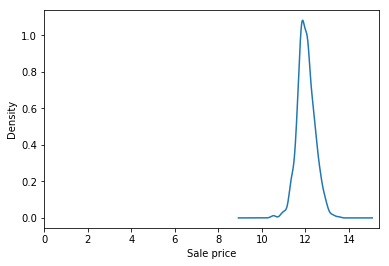

In [7]:
np.log(houses['SalePrice']).plot(kind='kde')
plt.xlim(xmin=0)
plt.xlabel('Sale price')
plt.show()

## Data preparation

In [8]:
CATEGORICALS = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
               'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
               'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
               'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType','GarageFinish',
               'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


def clean_dataset(dataset):
    clean = dataset.copy(deep=True)
    clean.drop('Id', axis=1, inplace=True)
    
    # Replace NA in categorical columns with string 'missing', in numericals with avg
    for column in clean.columns.values:
        if clean[column].isnull().sum() > 0:
            if column in CATEGORICALS:
                clean[column].fillna('missing', inplace=True)
            else:
                clean[column].fillna( clean[column].mean(), inplace=True )
                
    return clean

def dummies_train_test(train_dataset, test_dataset):
    ''' Asuming both datasets have the same number of columns. Target column has been extracted.'''
    
    test_num = len(test_dataset)
    entire_dataset = pd.concat(objs=[train_dataset, test_dataset], axis=0)
    ed_preprocessed = pd.get_dummies(entire_dataset)
    dummy_train = ed_preprocessed[:test_num + 1]
    dummy_test = ed_preprocessed[test_num + 1:]
    return [dummy_train, dummy_test]

In [9]:
houses_clean = clean_dataset(houses)
test_clean = clean_dataset(test)

houses_y = houses_clean['SalePrice']
houses_clean.drop('SalePrice', axis=1, inplace=True)

[houses_dummy, test_dummy] = dummies_train_test(houses_clean, test_clean)

## Experiment preparation

In [10]:
X = houses_dummy
y = houses_y

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1)
    
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [50]:
# Root Mean Squared Log Error
# See more at: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError

def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5

## Decision Tree
http://scikit-learn.org/stable/modules/tree.html

In [52]:
# Maximize score

dec_tree = tree.DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=60,min_samples_split=2,                                       max_features=None, max_leaf_nodes=500, presort=False)
dec_tree.fit(X_train, y_train)
dec_tree_score = regr.score(X_test, y_test)

In [55]:
# Test
dec_tree_rmsle = rmsle(dec_tree.predict(X_test), y_test)
print(dec_tree_rmsle)

0.199192478006


In [56]:
# Validation
dec_tree_rmsle_val = rmsle(dec_tree.predict(X_val), y_val)
dec_tree_rmsle_val

0.19986196650115251

In [93]:
res = pd.DataFrame(test['Id']).join(pd.DataFrame(dec_tree.predict(test_dummy)))
res.columns = ['Id', 'SalePrice']

In [328]:
res.to_csv('../data/res_decision_tree_regression_sub3.csv', index=False)

## Another approach: Random forests

In [91]:
rnd_forest = RandomForestRegressor(n_estimators=100, max_features=None,min_samples_split=2, n_jobs=-1)
rnd_forest.fit(X_train, y_train)
rnd_forest_rmsle = rmsle(rnd_forest.predict(X_test), y_test)
print("Test RMSLE: " + str(rnd_forest_rmsle))
rnd_forest_rmsle_val = rmsle(rnd_forest.predict(X_val), y_val)
print("Val RMSLE: " + str(rnd_forest_rmsle_val))

Test RMSLE: 0.144249854013
Val RMSLE: 0.125163600007


In [94]:
prediction = rnd_forest.predict(test_dummy)
res = pd.DataFrame(test['Id']).join(pd.DataFrame(prediction))
res.columns = ['Id', 'SalePrice']

In [95]:
res.to_csv('../data/res_random_forest_2.csv', index=False) #Kaggle: 0.15305

### Log scale
Spoiler: Best so far in Kaggle comp.

In [97]:
rnd_forest_log_model = RandomForestRegressor(n_estimators=100, max_features=None,min_samples_split=2, n_jobs=-1)
rnd_forest_log_model.fit(X_train, np.log(y_train))

rnd_forest_log_model_rmsle = rmsle(rnd_forest_log_model.predict(X_test), y_test)
print("Test RMSLE: " + str(rnd_forest_log_model_rmsle))
rnd_forest_log_model_rmsle = rmsle(rnd_forest_log_model.predict(X_val), y_val)
print("Val RMSLE: " + str(rnd_forest_log_model_rmsle))

Test RMSLE: 9.42972149012
Val RMSLE: 9.47832982407


In [98]:
prediction = rnd_forest_log_model.predict(test_dummy)
res = pd.DataFrame(test['Id']).join(pd.DataFrame(np.exp(prediction)))
res.columns = ['Id', 'SalePrice']

In [99]:
res.to_csv('../data/res_random_forest_log_1.csv', index=False) # Kaggle: 0.14999

## Boosted Trees